### Analysis Notebook to compute key statistics from the logs

To analyze the results and to be able to present the results of the agents' performance to Multiverse Smaug, we will create a Jupyter notebook that computes key statistics from the logs generated during the experiments. The notebook will read the log files, process the data, and generate visualizations to help interpret the results.

Since we know, that in the first run we ranked 4th place, and in the second run 5th place, we can find out the ID of our agent by recreating the rankings from the logs.

In [81]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOG_DIR = Path("feedback")
LOG_FILE_ROUND_1 = LOG_DIR / "auction_house_log_1.jsonln"
LOG_FILE_ROUND_2 = LOG_DIR / "auction_house_log_2.jsonln"

In [82]:
def extract_final_states(log_path):
    """
    Read a JSONL auction log and reconstruct the final gold/points
    for each agent_id based on the latest 'states' snapshot.
    """
    final_states = {}  # agent_id -> {"gold": x, "points": y}

    with open(log_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            row = json.loads(line)

            states = row.get("states", {})
            # overwrite state each time -> last one in the file is final
            for aid, st in states.items():
                final_states[aid] = {
                    "gold": st.get("gold", 0),
                    "points": st.get("points", 0),
                }

    return final_states

final_states_run1 = extract_final_states(LOG_FILE_ROUND_1)
final_states_run2 = extract_final_states(LOG_FILE_ROUND_2)
len(final_states_run1), list(final_states_run1.items())[:3]  # small preview

(28,
 [('b0efa0f298525bfc1c89465441313d859c3214ba5720eb4a875e30dceb7203a6',
   {'gold': 897766, 'points': 25002}),
  ('d2e99e63c4c562a05b9ec909af5e048362d6f4858e909f1e1fa94985cd2ea5df',
   {'gold': 33582, 'points': 27101}),
  ('f52757716c10928be1ae5de824862a1e8b915b2a2373b8b67297f2fdbc15d38f',
   {'gold': 9123, 'points': 264})])

In [83]:
def make_ranking_df(final_states: dict) -> pd.DataFrame:
    """
    Convert final_states dict (agent_id -> gold/points) into
    a sorted pandas DataFrame.
    """
    df = (
        pd.DataFrame.from_dict(final_states, orient="index")
        .rename_axis("agent_id")
        .reset_index()
    )
    # Sort by points (descending), then gold as tie-breaker
    df = df.sort_values(["points", "gold"], ascending=[False, False]).reset_index(drop=True)
    df.insert(0, "rank", df.index + 1)
    return df

In [84]:
ranking_run1 = make_ranking_df(final_states_run1)
ranking_run1

,rank,agent_id,gold,points
0,1,0c35356f6a860ea74dccdb8f13b5144325ac8575b01664...,5692,54081
1,2,19f23cdd12eb4550050bc9d6bcd4ebc6076aa759b11c2a...,10998,44862
2,3,89f9ffe3f3c25389940fecfaa75ae9189c9a34a282e05f...,4203,40710
3,4,8aeb7c6ece09a5b9157348b0e50367548b44d7f88d04b0...,3209,33542
4,5,503112b1880e91cd54957cc9247d12a2ecb3d3941034f8...,26545,32297
5,6,629680ccdb33dfcb9fc60551551251e76d42bf6042546f...,8138,31122
6,7,d2e99e63c4c562a05b9ec909af5e048362d6f4858e909f...,33582,27101
7,8,b0efa0f298525bfc1c89465441313d859c3214ba5720eb...,897766,25002
8,9,a36132e0cdc91ddd94b16ee5f23bf56cb46799c3bd1250...,9061,24131
9,10,19e2a5b335f5bc6069e277b29f540e3cdcc4effa36cc03...,7389,21049


In [85]:
ranking_run2 = make_ranking_df(final_states_run2)
ranking_run2

,rank,agent_id,gold,points
0,1,0c35356f6a860ea74dccdb8f13b5144325ac8575b01664...,6978,42529
1,2,d5c9e8aef619591b409046e72c54d93ff10b9e8f3942a6...,503,42441
2,3,19f23cdd12eb4550050bc9d6bcd4ebc6076aa759b11c2a...,4084,30333
3,4,0fdb9c330f283191d580393a7b70cdfc69681a696ee53e...,11098,29542
4,5,8aeb7c6ece09a5b9157348b0e50367548b44d7f88d04b0...,4642,27313
5,6,89f9ffe3f3c25389940fecfaa75ae9189c9a34a282e05f...,6042,26615
6,7,503112b1880e91cd54957cc9247d12a2ecb3d3941034f8...,29432,25961
7,8,19e2a5b335f5bc6069e277b29f540e3cdcc4effa36cc03...,18334,24908
8,9,419e6df1265569ddc0b29283c7856b448516cb7cbe2e8e...,8755,24374
9,10,b0efa0f298525bfc1c89465441313d859c3214ba5720eb...,2230,23299


In [86]:
agent_id_run1 = ranking_run1[ranking_run1["rank"] == 4]["agent_id"].values[0]
agent_id_run2 = ranking_run2[ranking_run2["rank"] == 5]["agent_id"].values[0]

MY_ID = agent_id_run1  # our agent's ID

print("Both IDs are identical:", agent_id_run1 == agent_id_run2)
agent_id_run1, agent_id_run2

Both IDs are identical: True


('8aeb7c6ece09a5b9157348b0e50367548b44d7f88d04b03368385ad1e56ad197',
 '8aeb7c6ece09a5b9157348b0e50367548b44d7f88d04b03368385ad1e56ad197')

#### Round 1 Analysis

In [87]:
# --- Extract all auctions across rounds ---
rows_round_1 = []
with open(LOG_FILE_ROUND_1) as f:
    for line in f:
        row = json.loads(line)
        rnd = row.get("round")
        prev = row.get("prev_auctions", {})
        if rnd is None:
            continue

        for auc_id, auc in prev.items():
            bids = auc.get("bids", [])
            reward = auc.get("reward", 0)

            # did we bid?
            my_bid = None
            for b in bids:
                if b["a_id"] == MY_ID:
                    my_bid = b["gold"]

            participated = my_bid is not None
            won = (len(bids)>0 and bids[0]["a_id"] == MY_ID)

            rows_round_1.append({
                "round": rnd,
                "participated": participated,
                "won": won,
                "my_bid": my_bid if my_bid is not None else 0,
                "reward": reward,
                "winner_bid": bids[0]["gold"] if len(bids)>0 else None
            })

df_1 = pd.DataFrame(rows_round_1)

# --- Core Metrics ---
total_auctions_1      = len(df_1)
my_participations_1   = df_1["participated"].sum()
my_wins_1             = df_1["won"].sum()
win_rate_1            = my_wins_1 / total_auctions_1
win_if_participated_1 = my_wins_1 / my_participations_1 if my_participations_1 > 0 else 0
participation_rate_1  = my_participations_1 / total_auctions_1

# Efficiency: gold spent per reward (only when winning)
df_eff_1 = df_1[(df_1["won"]) & (df_1["reward"] > 0)]
efficiency_avg_1 = (df_eff_1["my_bid"] / df_eff_1["reward"]).mean() if len(df_eff_1)>0 else np.nan

# Total points, ranking and gold after round 1
row = ranking_run1[ranking_run1["agent_id"] == MY_ID]
if not row.empty:
    my_final_state_1 = row.iloc[0].to_dict()
else:
    my_final_state_1 = {"rank": 0, "gold": 0, "points": 0}

# --- Display ---
print("=== CORE METRICS Round 1 ===")
print(f"Final Rank:               {my_final_state_1.get('rank')}")
print(f"Final Points:             {my_final_state_1.get('points')}")
print(f"Final Gold:               {my_final_state_1.get('gold')}")
print(f"Total auctions:           {total_auctions_1}")
print(f"Number of participations: {my_participations_1}")
print(f"Number of wins:           {my_wins_1}")
print(f"Participation rate:       {participation_rate_1:.3f}")
print(f"Overall win rate:         {win_rate_1:.3f}")
print(f"Win rate when bidding:    {win_if_participated_1:.3f}")
print(f"Avg bid efficiency (g/p): {efficiency_avg_1:.2f}")

=== CORE METRICS Round 1 ===
Final Rank:               4
Final Points:             33542
Final Gold:               3209
Total auctions:           41040
Number of participations: 3996
Number of wins:           1113
Participation rate:       0.097
Overall win rate:         0.027
Win rate when bidding:    0.279
Avg bid efficiency (g/p): 43.02


#### Round 2 Analysis

In [88]:
# --- Extract all auctions across rounds ---
rows_round_2 = []
with open(LOG_FILE_ROUND_2) as f:
    for line in f:
        row = json.loads(line)
        rnd = row.get("round")
        prev = row.get("prev_auctions", {})
        if rnd is None:
            continue

        for auc_id, auc in prev.items():
            bids = auc.get("bids", [])
            reward = auc.get("reward", 0)

            # did we bid?
            my_bid = None
            for b in bids:
                if b["a_id"] == MY_ID:
                    my_bid = b["gold"]

            participated = my_bid is not None
            won = (len(bids)>0 and bids[0]["a_id"] == MY_ID)

            rows_round_2.append({
                "round": rnd,
                "participated": participated,
                "won": won,
                "my_bid": my_bid if my_bid is not None else 0,
                "reward": reward,
                "winner_bid": bids[0]["gold"] if len(bids)>0 else None
            })

df_2 = pd.DataFrame(rows_round_2)

# --- Core Metrics ---
total_auctions_2      = len(df_2)
my_participations_2   = df_2["participated"].sum()
my_wins_2             = df_2["won"].sum()
win_rate_2            = my_wins_2 / total_auctions_2
win_if_participated_2 = my_wins_2 / my_participations_2 if my_participations_2 > 0 else 0
participation_rate_2  = my_participations_2 / total_auctions_2

# Efficiency: gold spent per reward (only when winning)
df_eff_2 = df_2[(df_2["won"]) & (df_2["reward"] > 0)]
efficiency_avg_2 = (df_eff_2["my_bid"] / df_eff_2["reward"]).mean() if len(df_eff_2)>0 else np.nan

# Total points, ranking and gold after round 2
row = ranking_run2[ranking_run2["agent_id"] == MY_ID]

if not row.empty:
    my_final_state_2 = row.iloc[0].to_dict()
else:
    my_final_state_2 = {"rank": 0, "gold": 0, "points": 0}

# --- Display ---
print("=== CORE METRICS Round 2 ===")
print(f"Final Rank:               {my_final_state_2.get('rank')}")
print(f"Final Points:             {my_final_state_2.get('points')}")
print(f"Final Gold:               {my_final_state_2.get('gold')}")
print(f"Total auctions:           {total_auctions_2}")
print(f"Number of participations: {my_participations_2}")
print(f"Number of wins:           {my_wins_2}")
print(f"Participation rate:       {participation_rate_2:.3f}")
print(f"Overall win rate:         {win_rate_2:.3f}")
print(f"Win rate when bidding:    {win_if_participated_2:.3f}")
print(f"Avg bid efficiency (g/p): {efficiency_avg_2:.2f}")

=== CORE METRICS Round 2 ===
Final Rank:               5
Final Points:             27313
Final Gold:               4642
Total auctions:           43956
Number of participations: 3924
Number of wins:           934
Participation rate:       0.089
Overall win rate:         0.021
Win rate when bidding:    0.238
Avg bid efficiency (g/p): 50.39


,Final Rank,Final Points,Final Gold,Total auctions,Participations,Wins,Participation rate,Overall win rate,Win rate when bidding,Avg bid efficiency (g/p)
Run,,,,,,,,,,
1,4,33542,3209,41040,3996,1113,0.097,0.027,0.279,43.02
2,5,27313,4642,43956,3924,934,0.089,0.021,0.238,50.39


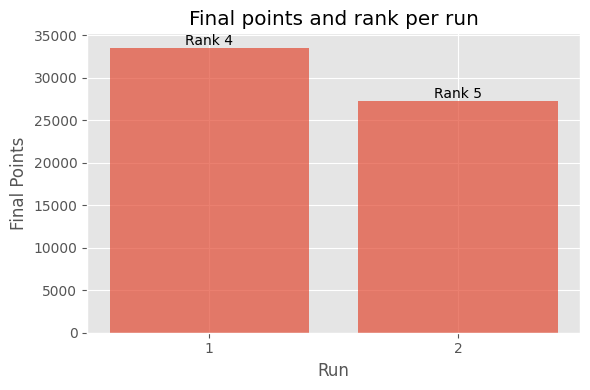

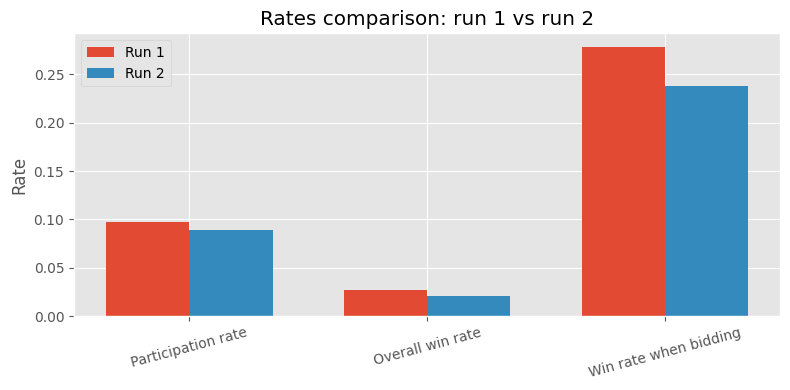

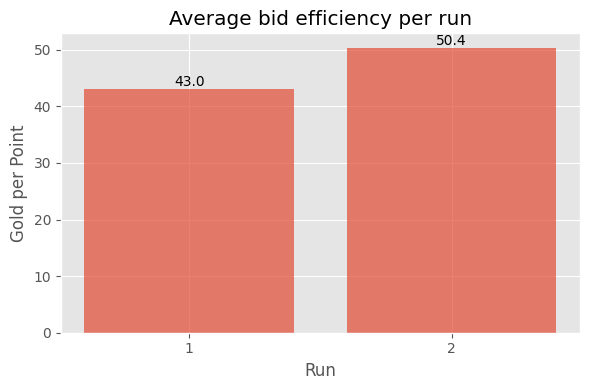

In [89]:
# plt.style.use("ggplot")  # simple modern look

# --- Raw metrics from your printouts -----------------------------------------
data = {
    "Run": [1, 2],
    "Final Rank": [my_final_state_1.get('rank'), my_final_state_2.get('rank')],
    "Final Points": [my_final_state_1.get('points'), my_final_state_2.get('points')],
    "Final Gold": [my_final_state_1.get('gold'), my_final_state_2.get('gold')],
    "Total auctions": [total_auctions_1, total_auctions_2],
    "Participations": [my_participations_1, my_participations_2],
    "Wins": [my_wins_1, my_wins_2],
    "Participation rate": [participation_rate_1, participation_rate_2],
    "Overall win rate": [win_rate_1, win_rate_2],
    "Win rate when bidding": [win_if_participated_1, win_if_participated_2],
    "Avg bid efficiency (g/p)": [efficiency_avg_1, efficiency_avg_2],
}

df_runs = pd.DataFrame(data).set_index("Run")

# --- 1) Nice comparison table -----------------------------------------------
display(df_runs.style.format({
    "Participation rate": "{:.3f}",
    "Overall win rate": "{:.3f}",
    "Win rate when bidding": "{:.3f}",
    "Avg bid efficiency (g/p)": "{:.2f}"
}).set_caption("Core metrics comparison: Run 1 vs Run 2"))

# --- 2) Plot: Final points and rank -----------------------------------------
fig, ax1 = plt.subplots(figsize=(6,4))

runs = df_runs.index.astype(str)

# bar for points
ax1.bar(runs, df_runs["Final Points"], alpha=0.7)
ax1.set_xlabel("Run")
ax1.set_ylabel("Final Points")
ax1.set_title("Final points and rank per run")

# annotate rank above bars
for x, pts, rank in zip(runs, df_runs["Final Points"], df_runs["Final Rank"]):
    ax1.text(x, pts, f"Rank {rank}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# --- 3) Plot: win/participation/efficiency ----------------------------------
fig, ax = plt.subplots(figsize=(8,4))

metrics = ["Participation rate", "Overall win rate", "Win rate when bidding"]
x = range(len(metrics))

width = 0.35
ax.bar([i - width/2 for i in x], df_runs.loc[1, metrics], width, label="Run 1")
ax.bar([i + width/2 for i in x], df_runs.loc[2, metrics], width, label="Run 2")

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylabel("Rate")
ax.set_title("Rates comparison: run 1 vs run 2")
ax.legend()

plt.tight_layout()
plt.show()

# --- 4) Plot: bid efficiency -------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(runs, df_runs["Avg bid efficiency (g/p)"], alpha=0.7)
ax.set_xlabel("Run")
ax.set_ylabel("Gold per Point")
ax.set_title("Average bid efficiency per run")

for x, eff in zip(runs, df_runs["Avg bid efficiency (g/p)"]):
    ax.text(x, eff, f"{eff:.1f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()